In [16]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from tensorflow.keras import mixed_precision
import gdown
# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Check available devices
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

# Explicitly allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print("RuntimeError:",e)


# Optional: Force GPU usage if available
with tf.device('/GPU:0'):
    # Your data loading code here
    pass



Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [17]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=4d65237e-8dfd-44c4-a319-1af32a638fe1
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 209MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [18]:
import glob
video_files = glob.glob('data/s1/*.mpg')
align_files = glob.glob('data/alignments/s1/*.align')
print(f"Number of video files: {len(video_files)}, Number of alignment files: {len(align_files)}")


Number of video files: 1000, Number of alignment files: 1000


In [19]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)


def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

######################################################################################
def load_alignments(path):
    tokens = []

    # Read the alignment file and extract tokens
    with open(path, 'r') as f:
        for line in f:
            line = line.split()
            if line[2] != 'sil':  # Skip silence tokens ('sil')
                tokens.extend([' ', line[2]])  # Add space and token to the list

    # Convert list of tokens to a TensorFlow string tensor (which may return a RaggedTensor)
    tokens = tf.convert_to_tensor(tokens) # MODIFIED
    token_to_char = tf.strings.unicode_split(tokens, input_encoding='UTF-8')

    flattened_token_to_char = token_to_char.flat_values

    one_dim_vector = tf.reshape(flattened_token_to_char, (-1))

    conversion = char_to_num(one_dim_vector)[1:]

    return conversion

######################################################################################
def load_data(path: str):
    # Convert path tensor to a string and replace backslashes with forward slashes
    path = path.numpy().decode('utf-8').replace('\\', '/')
    #print(f"Original path after conversion: {path}")

    # Extract file name from the path
    file_name = os.path.basename(path).split('.')[0]
    #print(f"Extracted file name: {file_name}")  # Debugging statement

    # Construct video and alignment paths
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    # Print constructed paths for debugging
    #print(f"Video Path: {video_path}")
    #print(f"Alignment Path: {alignment_path}")

    # Check if the video file exists
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")

    # Check if the alignment file exists
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")

    # Loading data (replace these with actual implementations)
    frames = load_video(video_path)       # Placeholder function
    alignments = load_alignments(alignment_path)  # Placeholder function

    return frames, alignments

#############################################################################
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result
#############################################################################




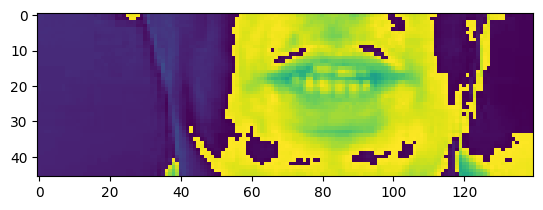

In [20]:
# Run function with test path and load frames for plotting
test_path = tf.convert_to_tensor('.\\data\\s1\\bbal6n.mpg')
frames, alignments = load_data(test_path)
plt.imshow(frames[40])

## Pipeline:

In [21]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)


# Added for split
train = data.take(450)
test = data.skip(450)
print('# of inputs:',len(test))
train

#len(frames)
sample = data.as_numpy_iterator()
val = sample.next(); val[0]
fv = (val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif', fv, duration=100)


# of inputs: 50


## DL design:

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [23]:
'''# Three Conv3D layers withh ReLu activation funcs.
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))
model.add(tf.keras.layers.Reshape((75,-1)))
model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))'''

"# Three Conv3D layers withh ReLu activation funcs.\nmodel = Sequential()\nmodel.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(Conv3D(256, 3, padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(Conv3D(75, 3, padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\nmodel.add(tf.keras.layers.Reshape((75,-1)))\nmodel.add(TimeDistributed(Flatten()))\n\nmodel.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))\nmodel.add(Dropout(.5))\n\nmodel.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))\nmodel.add(Dropout(.5))\n\nmodel.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))"

In [24]:
### Youtube GRU Model ###
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPool3D, Activation, Flatten, Dense, Dropout, GRU, TimeDistributed
import tensorflow as tf

model = Sequential()

# 3D Convolutional Layers
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))  # No change here
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))  # No change here
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))  # No change here
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Explicit reshape for compatibility
model.add(tf.keras.layers.Reshape((75, -1)))  # No change here

model.add(TimeDistributed(Flatten()))  # No change here

# Temporal layers with GRU (Change made here)
model.add(GRU(128, kernel_initializer='Orthogonal', return_sequences=True))  # Changed from Bidirectional GRU to standard GRU
model.add(Dropout(.5))

model.add(GRU(128, kernel_initializer='Orthogonal', return_sequences=True))  # Changed from Bidirectional GRU to standard GRU
model.add(Dropout(.5))

# Fully connected layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))  # No change here


In [25]:
char_to_num.vocabulary_size()

40

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 75, 128)             │       2,497,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 75, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75, 41)              │           5,289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,009,332 (15.29 MB)

 Trainable params: 4,009,332 (15.29 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


In [28]:
print(model.input_shape)
print(model.output_shape)

(None, 75, 46, 140, 1)
(None, 75, 41)


## Training preset and test:  

In [29]:
from keras.callbacks import ModelCheckpoint

In [32]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        # Ensure yhat is float32 before decoding
        yhat = tf.cast(yhat, dtype=tf.float32)  #dtype float32
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

#########################################################################################
previous_ckpt = 'models/checkpoint_epoch_010_val_loss_53.452.weights.h5'
model.load_weights(previous_ckpt)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# Updaded checkpoint callback
#ckpt_path = 'models/ep100_best_ckpt_.weights.h5'
ckpt_path = 'models/checkpoint_epoch_{epoch:03d}_val_loss_{val_loss:.3f}.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath= ckpt_path,
    #save_freq='epoch',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    #verbose=1 # Display saving status
)
schedule_callback = LearningRateScheduler(scheduler)

example_callback = ProduceExample(test)

model.fit(train, validation_data=test, epochs=90, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/90
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
Original: set blue in a one soon
Prediction: la re t e oan
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red at h six please
Prediction: la re t e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - loss: 57.4144 - val_loss: 52.9390 - learning_rate: 1.0000e-04
Epoch 2/90
  1/450 ━━━━━━━━━━━━━━━━━━━━ 8:12 1s/step - loss: 61.2463

UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  Error in user-defined function passed to MapDataset:29 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-19-1ddc8224679c>", line 73, in load_data
    alignments = load_alignments(alignment_path)  # Placeholder function

  File "<ipython-input-19-1ddc8224679c>", line 35, in load_alignments
    token_to_char = tf.strings.unicode_split(tokens, input_encoding='UTF-8')

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5983, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[StatefulPartitionedCall/compile_loss/ctc_loss/CTCLoss/_78]]
  (1) UNKNOWN:  Error in user-defined function passed to MapDataset:29 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-19-1ddc8224679c>", line 73, in load_data
    alignments = load_alignments(alignment_path)  # Placeholder function

  File "<ipython-input-19-1ddc8224679c>", line 35, in load_alignments
    token_to_char = tf.strings.unicode_split(tokens, input_encoding='UTF-8')

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5983, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_44279]

In [33]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        # Ensure yhat is float32 before decoding
        yhat = tf.cast(yhat, dtype=tf.float32)  #dtype float32
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

#########################################################################################
previous_ckpt = 'models/checkpoint_epoch_001_val_loss_52.939.weights.h5'
model.load_weights(previous_ckpt)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# Updaded checkpoint callback
#ckpt_path = 'models/ep100_best_ckpt_.weights.h5'
ckpt_path = 'models/checkpoint_epoch_{epoch:03d}_val_loss_{val_loss:.3f}.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath= ckpt_path,
    #save_freq='epoch',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    #verbose=1 # Display saving status
)
schedule_callback = LearningRateScheduler(scheduler)

example_callback = ProduceExample(test)

model.fit(train, validation_data=test, epochs=90, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/90
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Original: lay green with m seven soon
Prediction: la re i t e e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue in b seven soon
Prediction: la re i e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - loss: 56.3320 - val_loss: 51.4879 - learning_rate: 1.0000e-04
Epoch 2/90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Original: set red with v one soon
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue by c four now
Prediction: la re t re ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - loss: 55.1946 - val_loss: 50.4548 - learning_rate: 1.0000e-04
Epoch 3/90
1/1 ━━━━━━━━━━━━━━━━━━

UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  Error in user-defined function passed to MapDataset:29 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 103680 values, but the requested shape has 311040 [Op:Reshape]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-19-1ddc8224679c>", line 72, in load_data
    frames = load_video(video_path)       # Placeholder function

  File "<ipython-input-19-1ddc8224679c>", line 14, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 103680 values, but the requested shape has 311040 [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[StatefulPartitionedCall/compile_loss/ctc_loss/CTCLoss/_78]]
  (1) UNKNOWN:  Error in user-defined function passed to MapDataset:29 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 103680 values, but the requested shape has 311040 [Op:Reshape]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-19-1ddc8224679c>", line 72, in load_data
    frames = load_video(video_path)       # Placeholder function

  File "<ipython-input-19-1ddc8224679c>", line 14, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 103680 values, but the requested shape has 311040 [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_4683378]

In [34]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        # Ensure yhat is float32 before decoding
        yhat = tf.cast(yhat, dtype=tf.float32)  #dtype float32
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

#########################################################################################
previous_ckpt = 'models/checkpoint_epoch_006_val_loss_44.496.weights.h5'
#model.load_weights(previous_ckpt)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# Updaded checkpoint callback
#ckpt_path = 'models/ep100_best_ckpt_.weights.h5'
ckpt_path = 'models/checkpoint_epoch_{epoch:03d}_val_loss_{val_loss:.3f}.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath= ckpt_path,
    #save_freq='epoch',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    #verbose=1 # Display saving status
)
schedule_callback = LearningRateScheduler(scheduler)

example_callback = ProduceExample(test)

model.fit(train, validation_data=test, epochs=90, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/90
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - loss: 48.9941

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
Original: lay red in d nine soon
Prediction: la re it oe on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by h three soon
Prediction: la re t re eon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - loss: 48.9945 - val_loss: 43.1627 - learning_rate: 1.0000e-04
Epoch 2/90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Original: place red with q five again
Prediction: la re it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in t four now
Prediction: la re it oe o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step - loss: 47.9093 - val_loss: 41.9753 - learning_rate: 1.0000e-04
Epoch 3/90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  Error in user-defined function passed to MapDataset:29 transformation with iterator: Iterator::Root::Prefetch::FiniteSkip::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-19-1ddc8224679c>", line 73, in load_data
    alignments = load_alignments(alignment_path)  # Placeholder function

  File "<ipython-input-19-1ddc8224679c>", line 35, in load_alignments
    token_to_char = tf.strings.unicode_split(tokens, input_encoding='UTF-8')

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5983, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  Error in user-defined function passed to MapDataset:29 transformation with iterator: Iterator::Root::Prefetch::FiniteSkip::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-19-1ddc8224679c>", line 73, in load_data
    alignments = load_alignments(alignment_path)  # Placeholder function

  File "<ipython-input-19-1ddc8224679c>", line 35, in load_alignments
    token_to_char = tf.strings.unicode_split(tokens, input_encoding='UTF-8')

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5983, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_26418838]

In [36]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        # Ensure yhat is float32 before decoding
        yhat = tf.cast(yhat, dtype=tf.float32)  #dtype float32
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

#########################################################################################
previous_ckpt = 'models/checkpoint_epoch_003_val_loss_40.632.weights.h5'
#model.load_weights(previous_ckpt)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# Updaded checkpoint callback
#ckpt_path = 'models/ep100_best_ckpt_.weights.h5'
ckpt_path = 'models/checkpoint_epoch_{epoch:03d}_val_loss_{val_loss:.3f}.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath= ckpt_path,
    #save_freq='epoch',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    #verbose=1 # Display saving status
)
schedule_callback = LearningRateScheduler(scheduler)

example_callback = ProduceExample(test)

model.fit(train, validation_data=test, epochs=90, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/90
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
Original: bin white by a seven again
Prediction: pla re by ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in j nine again
Prediction: pla re it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - loss: 43.6542 - val_loss: 37.3925 - learning_rate: 1.0000e-04
Epoch 2/90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Original: set red by o four please
Prediction: pla re y ore leae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with g five again
Prediction: pla gre it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - loss: 42.0532 - val_loss: 36.9928 - learning_rate: 1.0000e-04
Epoch 3/90
1/1 ━━━━━━━

UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  Error in user-defined function passed to MapDataset:29 transformation with iterator: Iterator::Root::Prefetch::FiniteSkip::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 311040 values, but the requested shape has 103680 [Op:Reshape]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-19-1ddc8224679c>", line 72, in load_data
    frames = load_video(video_path)       # Placeholder function

  File "<ipython-input-19-1ddc8224679c>", line 14, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 311040 values, but the requested shape has 103680 [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  Error in user-defined function passed to MapDataset:29 transformation with iterator: Iterator::Root::Prefetch::FiniteSkip::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 311040 values, but the requested shape has 103680 [Op:Reshape]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-19-1ddc8224679c>", line 72, in load_data
    frames = load_video(video_path)       # Placeholder function

  File "<ipython-input-19-1ddc8224679c>", line 14, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 311040 values, but the requested shape has 103680 [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_40066122]

## Prediction:

In [ ]:
import os

# List files in the models directory
print("Files in models directory:", os.listdir("models"))
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(ckpt_path).expect_partial()

model.load_weights(os.path.join('models', 'model_best_checkpoint.weights.h5'))
print(os.path.exists('models/checkpoint.h5'))

In [ ]:
test_data = test.as_numpy_iterator()
sample = test_data.next()
yhat = model.predict(sample[0])
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]



## Test on video:

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

yhat = model.predict(tf.expand_dims(sample[0], axis=0))

decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]